# Transformations and pipelines in Scikit-Learn

We begin by looking at a reduced version of the MNIST digits. The first things we should probably do is get an idea on the dimensionality of the data. What does is look like? How many features do I have? How many examples do I have?

Although this isn't a machine learning course, we'll have to cover some ML terminology:

- __examples__ The individual data points. For example, you are conducting a study on the relationship between biomarkers and sleep state. You want to know whether you can predict the sleep cycle stage based on the biomarkers of skin temperature, heart-rate, and breathing rate. You take these readings every 5 minutes. Each 5 minute reading of the biomarkers constitutes an example (or sometimes called instance).

- __features__ The different attributes that your examples have. In the sleep study analogy, the biomarkers are the features. In this case, each example has 3 features. The _feature space_ is therefore 3-dimensional, where each axis is a feature. We can then plot the examples in this 3D space.

In [1]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
plt.rcParams['axes.axisbelow'] = True

import numpy as np

In [2]:
digits = load_digits()

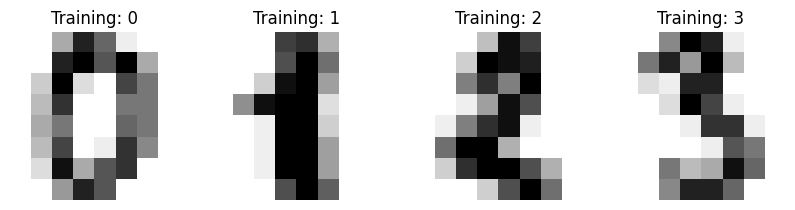

In [3]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

We separate the data into training and testing sets. We leave the testing set alone and we never touch it during any of the training.

Note: The following scenario is incredibly tempting, and surprisingly common, especially in fields unfamiliar with the typical ML workflow.

I take my data and split it into training and testing sets. I come up with a model that performs well on the training data, and then see how it performs on the test set. It doesn't do very well, so I come up different models. I keep trying until I get good performance on the testing set. Job done! 

Why isn't this a good idea?

In [4]:
# Test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)

print(y_train.shape, y_val.shape, y_test.shape)

(1010,) (337,) (450,)


In [34]:
print(f"Number of training examples: {X_train.shape[0]}")
print(f"Number of testing examples: {X_test.shape[0]}")
print(f"Number of validation examples: {X_val.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Number of training examples: 1010
Number of testing examples: 450
Number of validation examples: 337
Number of features: 64


It's a nice idea to check to see whether the classes are _balanced_ or not. Imbalanced datasets can lead algorithms to develop a bias toward the majority class(es). We generally consider a dataset to be imbalanced when there is quite a heavy skew, so a slight imbalance like we have here is not always such a big deal. There are ways to offset an imbalanced dataset.

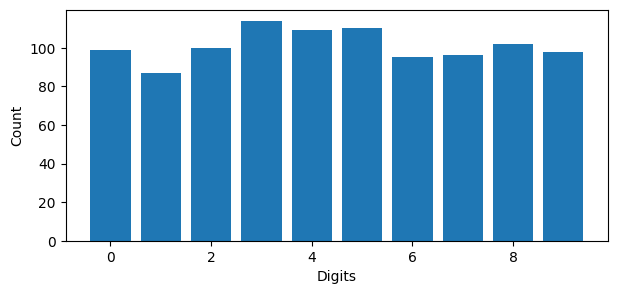

In [7]:
# distribution of training labels
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(7,3))
plt.bar(unique, counts)
plt.xlabel("Digits")
plt.ylabel("Count")
plt.show()

One of the first things you can do is look at the principal components of the data using [principal component analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA). PCA is a great algorithm: it's mathematically simple, very explainable, and can give you an idea of which features have the highest amount of variance. In some cases, a 2D PCA and a clustering algorithm or linear model can get you a long way...

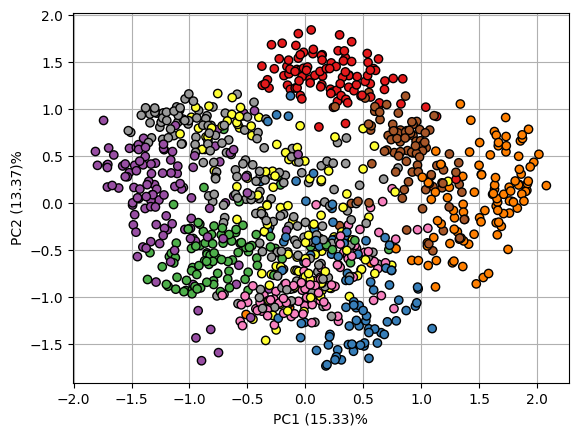

In [8]:
# Scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.2f})%")
plt.ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.2f})%")
plt.grid()
plt.show()

In our example, we can see that in 2D, the digits actually form pretty distinct groups. So we'll try using a [k-nearest neighbours classifier](https://scikit-learn.org/stable/modules/neighbors.html#classification) and see what we can do.

In [9]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)

# Test
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
y_pred = knn.predict(X_val_pca)

# Accuracy
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")

Accuracy: 0.63


So 63% on the validation data might not seem great, but consider what a baseline model would be. We use the Zero Rule as our baseline and pick the majority class in the training data: the number 3. 

In [10]:
# mode of the training labels
from scipy.stats import mode

mode = mode(y_train)[0]

baseline_model = np.ones(y_val.shape) * mode
print(f"Baseline accuracy: {accuracy_score(y_val, baseline_model):.2f}")

Baseline accuracy: 0.08


So actually, we are actually doing quite well with 63%. But of course we can do better!

In our original images, we had a 64-dimensional feature space, and we have compressed this down to 2! We could try and increase the number of principal component dimensions. In addition, we can also change the number of neighbours we can query. Looking at the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) and [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) documentation, we can see that PCA takes an argument `n_components`, and KNeighborsClassifier takes an argument `n_neighbours`. In a ML context, we call these _hyperparameters_ (or hypers for short). They are parameters that we can choose in order to get the best performance out of our model.

Before we play around with the hypers, let's condense the above code into a pipeline.

In [11]:

from sklearn.pipeline import Pipeline

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2)),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")

Accuracy: 0.63


We can also print out a handy diagram of the model:

In [12]:
estimator

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('classifier', KNeighborsClassifier())])

Feel free to play around with the hypers and see if you can get a better score. When you're happy, you can then run

```python
print(f"Final model accuracy: {accuracy_score( y_test, estimator.predict(X_test) ):.2f}" )
```

to get a final model score.

But that's inefficient. So instead, we'll actually [tune the hyperparameters](https://scikit-learn.org/stable/modules/grid_search.html#) using sklearn's `model_selection` method `GridSearchCV`.

These methods actually split our training data into training and validation sets, and uses [k-fold cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), so we don't need to manually perform this operation as we did before.

If your hyperparameter space is small (as it is in this case), an exhaustive grid search is fine. But if your hyperparameter space is very large, you can achieve as good (and sometimes better) results with `RandomizedSearchCV`. _Why do you think this is the case?_

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=1337)

param_grid = {
    "pca__n_components": np.arange(1, 64),
    "classifier__n_neighbors": np.arange(1, 64)
}

estimator = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()),
    ("classifier", KNeighborsClassifier())
])

# clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 3969 candidates, totalling 19845 fits


In [15]:
print(f"Best parameters: {search.best_params_}")

Best parameters: {'classifier__n_neighbors': 1, 'pca__n_components': 44}


In [16]:
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
                         'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])},
             verbose=1)

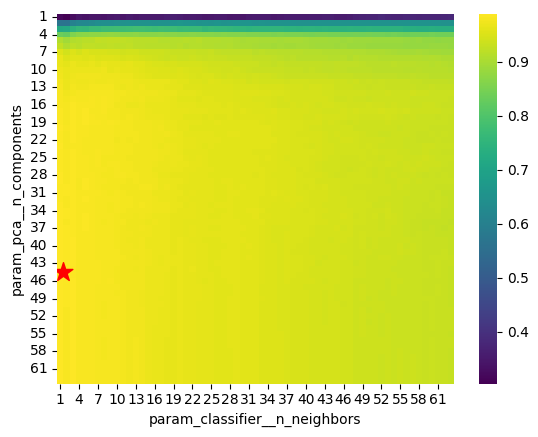

In [17]:
# plot heatmap of the validation accuracy as a function of n_components and n_neighbors
import pandas as pd

df = pd.DataFrame(search.cv_results_)

import seaborn as sns

sns.heatmap(df.pivot_table(index="param_pca__n_components", columns="param_classifier__n_neighbors", values="mean_test_score"),fmt=".3f", cmap="viridis")
plt.scatter(search.best_params_["classifier__n_neighbors"], search.best_params_["pca__n_components"], marker="*", s=200, c="r")

Now we can train the final model on the full training set and evaluate on the testing set.

In [21]:
search.best_estimator_.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.99


Solid.

Notice that we've used the `MinMaxScaler`, which squashes the feature values to between a minimum and maximum value (usually between 0 and 1). However there are two other scalers: `StandardScaler`, and `RobustScaler` ([check out the documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling))

What if we want to look at the impact of different scaling methods? There is no obvious way to do this in the pipeline, so we need to construct a custom scaler that we can initialize with a scaler of our choice. In general, you can create custom transformations using the BaseEstimator and TransformerMixin classes. We will also need to write our own `fit` and `transform` methods in order for them to be compatible with the `Pipeline`.

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class ScalerSelector(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X):
        return self.scaler.fit(X)

    def transform(self, X):
        return self.scaler.transform(X)

In [70]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=1337)

param_grid = {
    "scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "pca__n_components": np.arange(1, 64),
    "classifier__n_neighbors": np.arange(1, 64)
}

estimator = Pipeline([
    ("scaler", ScalerSelector()),
    ("pca", PCA()),
    ("classifier", KNeighborsClassifier())
])

# clf = RandomizedSearchCV(estimator, param_grid, n_iter=10000, cv=5, verbose=1, n_jobs=-1)
clf = GridSearchCV(estimator, param_grid, cv=5, verbose=1, n_jobs=-1)
search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 11907 candidates, totalling 59535 fits


In [71]:
print(f"Best parameters: {search.best_params_}")

Best parameters: {'classifier__n_neighbors': 1, 'pca__n_components': 46, 'scaler': MinMaxScaler()}


`MinMaxScaler` was the best anyway 😄

These custom transformation classes can get pretty complicated.

Note that this is not the only way to perform hyperparameter optimization. There are some great tools out there like [MLFlow](https://mlflow.org/) and [WandB](https://wandb.ai/site/sweeps). Both of these tools easily integrate with Scikit-learn, Tensorflow, and Pytorch.